# Deep Learning: Long Short-Term Memory (LSTM)


## 1. Introduction

Five years of AstraZeneca historical stock data will be used to predict Adjusted Close prices by building a multi-layer LSTM Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data. 



## 2. Install/import libraries

In [1]:
# !pip install yfinance as yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## 3. Import data

Read in AstraZeneca stock data for 2014-2019 downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [3]:
crude = yf.download("CL=F", start="2010-01-01", end="2023-01-15")
crude.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-09,73.470001,76.739998,73.470001,74.629997,74.629997,329290
2023-01-10,74.860001,75.919998,73.839996,75.120003,75.120003,307430
2023-01-11,74.779999,77.839996,74.309998,77.410004,77.410004,350891
2023-01-12,77.699997,79.160004,77.099998,78.389999,78.389999,307705
2023-01-13,78.320000,80.110001,77.970001,79.860001,79.860001,307705


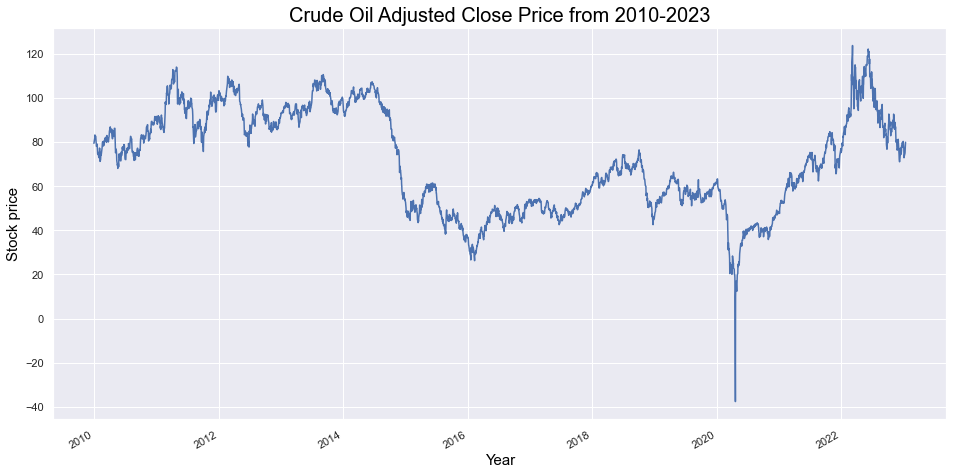

In [6]:
# Plot Adjusted Close price

crude['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('Crude Oil Adjusted Close Price from 2010-2023', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);


In [7]:
# Create DataFrame for Adjusted Close price

crude_adj = crude[['Adj Close']]

In [8]:
crude_adj

,Adj Close
Date,
2009-12-31,79.360001
2010-01-04,81.510002
2010-01-05,81.769997
2010-01-06,83.180000
2010-01-07,82.660004
...,...
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004


## 4. Create training data set

In [9]:
# Convert DataFrame to numpy array
crude_adj_arr = crude_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(crude_adj))

training_data_len

2625

In [10]:
# Create train data set

train = crude_adj_arr[0:training_data_len, :]

### Feature scaling

We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [11]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.77190552],
       [0.78609133],
       [0.78780679],
       ...,
       [0.50923726],
       [0.50026392],
       [0.50521245]])

In [12]:
train_scaled.shape

(2625, 1)

## Split training data into X_train, y_train

In [13]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
        print(X_train)
        print(y_train)
        print()

[array([0.77190552, 0.78609133, 0.78780679, 0.79711006, 0.7936791 ,
       0.7942729 , 0.79275532, 0.78134073, 0.77381896, 0.77210345,
       0.76293217, 0.76966216, 0.76042493, 0.75026393, 0.74010294,
       0.74485354, 0.74122459, 0.73436262, 0.73416468, 0.72921615,
       0.73937715, 0.7578517 , 0.75620219, 0.73086566, 0.71799949,
       0.7226181 , 0.73489047, 0.73997095, 0.74498548, 0.73739771,
       0.75640012, 0.75851149, 0.76992609, 0.77487462, 0.77718398,
       0.7686065 , 0.77612827, 0.76405383, 0.77388495, 0.76755078,
       0.77401689, 0.78186858, 0.77751385, 0.78602534, 0.78846663,
       0.78595934, 0.78991816, 0.79005015, 0.78430983, 0.77480868,
       0.78734493, 0.79546055, 0.79064395, 0.78061494, 0.78437582,
       0.78873056, 0.78015308, 0.77962522, 0.77612827, 0.79044602])]
[array([0.79176566])]

[array([0.77190552, 0.78609133, 0.78780679, 0.79711006, 0.7936791 ,
       0.7942729 , 0.79275532, 0.78134073, 0.77381896, 0.77210345,
       0.76293217, 0.76966216, 0.76

In [14]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2565, 60, 1)

### Create and train model

We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [16]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
41/41 [==============================] - 10s 91ms/step - loss: 0.0786
Epoch 2/200
41/41 [==============================] - 3s 81ms/step - loss: 0.0091
Epoch 3/200
41/41 [==============================] - 3s 82ms/step - loss: 0.0067
Epoch 4/200
41/41 [==============================] - 4s 86ms/step - loss: 0.0060
Epoch 5/200
41/41 [==============================] - 3s 83ms/step - loss: 0.0055
Epoch 6/200
41/41 [==============================] - 3s 81ms/step - loss: 0.0049
Epoch 7/200
41/41 [==============================] - 3s 82ms/step - loss: 0.0056
Epoch 8/200
41/41 [==============================] - 3s 79ms/step - loss: 0.0049
Epoch 9/200
41/41 [==============================] - 3s 84ms/step - loss: 0.0046
Epoch 10/200
41/41 [==============================] - 3s 81ms/step - loss: 0.0049
Epoch 11/200
41/41 [==============================] - 3s 81ms/step - loss: 0.0046
Epoch 12/200
41/41 [==============================] - 4s 86ms/step - loss: 0.0045
Epoch 13/200
41/41 [====

Epoch 101/200
41/41 [==============================] - 3s 83ms/step - loss: 0.0010
Epoch 102/200
41/41 [==============================] - 3s 81ms/step - loss: 0.0010
Epoch 103/200
41/41 [==============================] - 3s 79ms/step - loss: 0.0011
Epoch 104/200
41/41 [==============================] - 3s 80ms/step - loss: 0.0010
Epoch 105/200
41/41 [==============================] - 3s 82ms/step - loss: 9.1079e-04
Epoch 106/200
41/41 [==============================] - 3s 80ms/step - loss: 9.7227e-04
Epoch 107/200
41/41 [==============================] - 3s 79ms/step - loss: 9.7317e-04
Epoch 108/200
41/41 [==============================] - 3s 82ms/step - loss: 9.5129e-04
Epoch 109/200
41/41 [==============================] - 3s 82ms/step - loss: 9.2440e-04
Epoch 110/200
41/41 [==============================] - 3s 83ms/step - loss: 8.8023e-04
Epoch 111/200
41/41 [==============================] - 3s 81ms/step - loss: 9.0366e-04
Epoch 112/200
41/41 [==============================] - 3s 8

41/41 [==============================] - 3s 82ms/step - loss: 4.2331e-04
Epoch 196/200
41/41 [==============================] - 3s 78ms/step - loss: 3.9870e-04
Epoch 197/200
41/41 [==============================] - 3s 78ms/step - loss: 4.2043e-04
Epoch 198/200
41/41 [==============================] - 3s 78ms/step - loss: 4.3612e-04
Epoch 199/200
41/41 [==============================] - 3s 81ms/step - loss: 3.9051e-04
Epoch 200/200
41/41 [==============================] - 3s 79ms/step - loss: 4.5067e-04


### Create test set

In [17]:
test = crude_adj_arr[training_data_len: , :]

In [18]:
test.shape

(657, 1)

In [19]:
# Predicting 253 values, using past 60 from the train data
inputs = crude_adj_arr[len(crude_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [20]:
# Create data sets X_test and y_test
X_test = []
y_test = crude_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [21]:
# Convert data to numpy array
X_test = np.array(X_test)

In [22]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
print(X_test.shape)

(657, 60, 1)


### Make Predictions using the test set

In [24]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

21/21 [==============================] - 2s 21ms/step


In [25]:
predictions.shape

(657, 1)

### Calculate the RMSE using the actual values

RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [27]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

0.23332670725643906

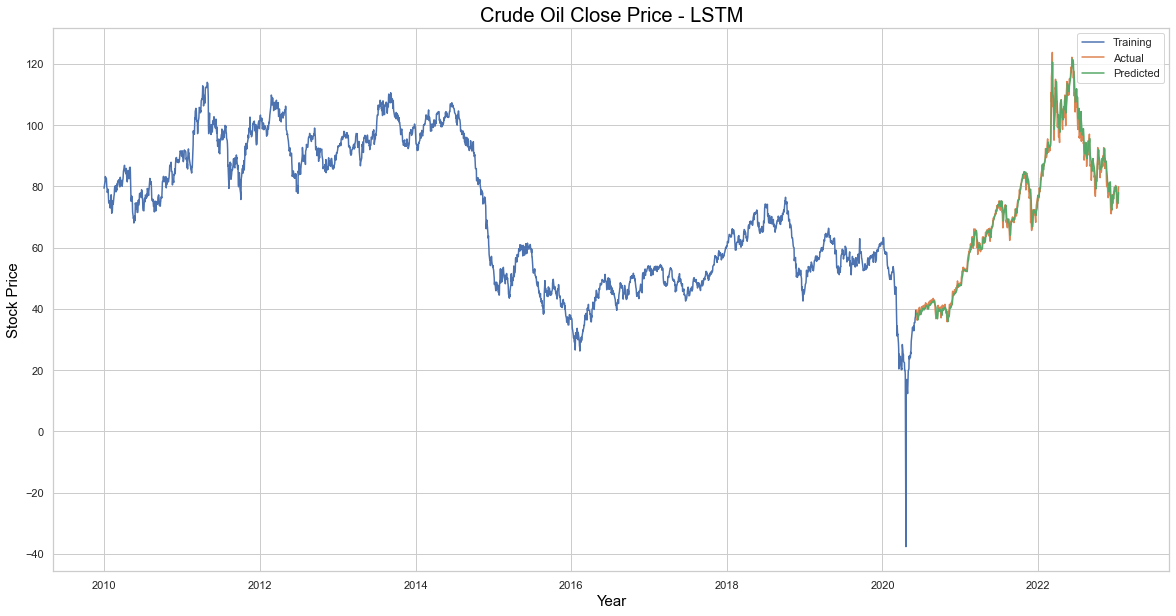

In [28]:
# Plot predicted vs actual values  
train = crude_adj[:training_data_len]
test = crude_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

### DataFrame of actual vs predicted prices plotted above

In [29]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2020-06-10,39.599998,38.219387
2020-06-11,36.340000,38.566895
2020-06-12,36.259998,37.845802
2020-06-15,37.119999,36.831959
2020-06-16,38.380001,36.407059
...,...,...
2023-01-09,74.629997,74.329712
2023-01-10,75.120003,74.607658
2023-01-11,77.410004,75.214058


### Predict Adjusted Close price for 13 Jan 2023

In [30]:
# Nifty_df = yf.download("^NSEI", start="2010-01-01", end="2023-01-15")
# Nifty_df

crude_quote = yf.download("CL=F", start="2010-01-01", end="2023-01-15")
crude_quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,79.279999,80.000000,79.160004,79.360001,79.360001,120372
2010-01-04,79.629997,81.680000,79.629997,81.510002,81.510002,263542
2010-01-05,81.629997,82.000000,80.949997,81.769997,81.769997,258887
2010-01-06,81.430000,83.519997,80.849998,83.180000,83.180000,370059
2010-01-07,83.199997,83.360001,82.260002,82.660004,82.660004,246632
...,...,...,...,...,...,...
2023-01-09,73.470001,76.739998,73.470001,74.629997,74.629997,329290
2023-01-10,74.860001,75.919998,73.839996,75.120003,75.120003,307430
2023-01-11,74.779999,77.839996,74.309998,77.410004,77.410004,350891


In [31]:
# Predict Adjusted Close price for Crude Oil stock for 15 Jan 2023   
# get the quote
crude_quote = yf.download("CL=F", start="2018-07-10", end="2023-01-14")
# Create new df
new_df = crude_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
last_60_days = new_df[-60:].values
# Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(last_60_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 47ms/step
[[79.341965]]


### Actual Adjusted Close price for 13 Jan 2023

In [32]:
# Actual price

crude_quote2 = yf.download("^NSEI", start="2023-01-12", end="2023-01-16")
print(crude_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2023-01-12    17858.199219
2023-01-13    17956.599609
Name: Adj Close, dtype: float64


The predicted Adjusted Close price for 02 Jan 2023 was 5829.4, lower than the actual price of 6024.7. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes. 